# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import TimestampType
from pyspark.sql.types import LongType
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler,MinMaxScaler,PCA, ChiSqSelector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier

import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Project: Sparkify") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Spark Project: Sparkify'),
 ('spark.app.id', 'local-1667601082409'),
 ('spark.driver.host', '62d5100279b5'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '35695'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
### load data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
user_log.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [5]:
### read data and check for data type
print(user_log.take(2))
print(user_log.dtypes)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]
[('artist', 'string'), ('auth', 'string'), ('firstName', 'string'), ('gender', 'string'), ('itemInSession', 'bigint'), ('lastName', 'string'), ('length', 'do

In [6]:
#Convert data type of userId and sessionId from string to integer
user_log=user_log.withColumn("userId",user_log["userId"].cast(IntegerType()))
user_log=user_log.withColumn("sessionId",user_log["sessionId"].cast(IntegerType()))
#user_log_data=user_log_data.withColumn("ts",user_log_data["ts"].cast(TimestampType()))

In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [8]:
df=user_log.toPandas()
df.describe()


,itemInSession,length,registration,sessionId,status,ts,userId
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05,278154.000000
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12,59682.022786
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09,109091.949999
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,2.000000
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12,51.000000
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12,98.000000
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12,100004.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,300025.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int32
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           278154 non-null float64
dtypes: float64(3), int32(1), int64(3), object(11)
memory usage: 38.3+ MB


In [10]:
df[df['userId'].duplicated()==True].count()

artist           227998
auth             286274
firstName        277929
gender           277929
itemInSession    286274
lastName         277929
length           227998
level            286274
location         277929
method           286274
page             286274
registration     277929
sessionId        286274
song             227998
status           286274
ts               286274
userAgent        277929
userId           277929
dtype: int64

In [11]:
#check for missing values
def missing (df1):
    missing_number = df1.isnull().sum().sort_values(ascending=False)
    missing_percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending=False)
    #missing_percent2=df1.isnull().sum() * 100 / len(df1)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
artist,58392,0.203812
song,58392,0.203812
length,58392,0.203812
userAgent,8346,0.029131
firstName,8346,0.029131
gender,8346,0.029131
lastName,8346,0.029131
userId,8346,0.029131
registration,8346,0.029131
location,8346,0.029131


In [12]:
### drop na rows
user_log_clean=user_log.dropna(how="any", subset=['userId'])

print(user_log_clean.count())
print(user_log.count())

278154
286500


In [13]:
### Get count of nan or missing values in pyspark

user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).show()

### Get count of null in pyspark
user_log.select([count(when (col(c).isNull(), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAge

In [14]:
user_log_clean.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)



In [15]:
df2=user_log_clean.toPandas()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 18 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int32
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null int32
dtypes: float64(1), int32(2), int64(4), object(11)
memory usage: 36.1+ MB


In [16]:
### Keep the result in a view
user_log_clean.createOrReplaceTempView("user_log_clean")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [17]:
### Define Churn
user_log_data=spark.sql('''
        select *,
        SUM(churn) OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS churn_phase
        from(
         select *, 
         case when page = "Cancellation Confirmation"
             then 1  else 0  end AS churn  
         from user_log_clean)
         '''
)

### Keep the result in a view
user_log_data.createOrReplaceTempView("user_log_data")

### Print schema and check for the record
user_log_data.printSchema()
user_log_df=user_log_data.toPandas()
user_log_df.head(5)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: integer (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- churn_phase: long (nullable = true)



,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,churn_phase
0,None,Logged In,Evan,M,11,Spencer,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,Logout,1537531076000,2102,None,307,1543589607000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,0
1,Lonnie Gordon,Logged In,Evan,M,10,Spencer,181.21098,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,2102,Catch You Baby (Steve Pitron & Max Sanna Radio...,200,1543589606000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,0
2,The Strokes,Logged In,Evan,M,9,Spencer,212.79302,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,2102,The Modern Age,200,1543589394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,0
3,Fleet Foxes,Logged In,Evan,M,8,Spencer,208.03873,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,2102,Tiger Mountain Peasant Song,200,1543589186000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,0
4,Radiohead,Logged In,Evan,M,7,Spencer,317.93587,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,2102,Weird Fishes/Arpeggi,200,1543588869000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,0


In [18]:
###Listing the activity of user 18 who canceled their service
spark.sql('''
  
         select userId,firstname, ts,page, churn,churn_phase
         from user_log_data
         where userId='18'
         order by ts desc
         '''
).collect()



[Row(userId=18, firstname='Adriel', ts=1538943990000, page='Cancellation Confirmation', churn=1, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538943740000, page='Cancel', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538943739000, page='Downgrade', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538943726000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538943440000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538943117000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538942837000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538942663000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538942425000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538942030000, page='NextSong', churn=0, churn_phase=1),
 Row(userId=18, firstnam

In [19]:
user_log_df.churn.value_counts()

0    278102
1        52
Name: churn, dtype: int64

In [20]:
### define churn
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_log_clean = user_log_clean.withColumn("Churn", flag_churn_event("page"))
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_clean = user_log_clean.withColumn('Churn_phase', Fsum('Churn').over(windowval))
user_log_clean.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn|Churn_phase|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+-----------+
|                null|Logged In|     Evan|     M|           11| Spencer|     null| free|Miami-Fort Lauder...|   PUT|     Logout|1537531076000|     2102|                null|   307|1543589607000|Mozilla/5.0 (Wind...|   148|    0|          0|
|       Lonnie Gordon|Logged In|    

In [21]:
df2=user_log_clean.toPandas()
###df2.Churn.value_counts(normalize=True)
df2.Churn.value_counts()

0    278102
1        52
Name: Churn, dtype: int64

In [22]:
###Listing the activity of user 18 who canceled their service
user_log_clean.select(["userId", "firstname", "ts", "page", "Churn", "Churn_phase"]).filter(user_log_clean.userId == "18").sort("ts").collect()

[Row(userId=18, firstname='Adriel', ts=1538499917000, page='Home', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538499933000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538500208000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538500476000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538500654000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538500842000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538500856000, page='Settings', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538501009000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538501340000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=1538501587000, page='NextSong', Churn=0, Churn_phase=1),
 Row(userId=18, firstname='Adriel', ts=15385

In [23]:
numerical= user_log_df.select_dtypes(include = 'number').columns
print(numerical)
categorical = user_log_df.select_dtypes(include = 'object').columns
print (f'Numberical columns: {user_log_df[numerical].columns}')
print (f'categorical columns: {user_log_df[categorical].columns}')

Index(['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts',
       'userId', 'churn', 'churn_phase'],
      dtype='object')
Numberical columns: Index(['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts',
       'userId', 'churn', 'churn_phase'],
      dtype='object')
categorical columns: Index(['artist', 'auth', 'firstName', 'gender', 'lastName', 'level',
       'location', 'method', 'page', 'song', 'userAgent'],
      dtype='object')


In [24]:
user_log_df[numerical].describe()

,itemInSession,length,registration,sessionId,status,ts,userId,churn,churn_phase
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,59682.022786,0.000187,0.161288
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,109091.949999,0.013672,0.367797
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,2.000000,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,51.000000,0.000000,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,98.000000,0.000000,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,100004.000000,0.000000,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,300025.000000,1.000000,1.000000


In [25]:
user_log_df[categorical].describe()

,artist,auth,firstName,gender,lastName,level,location,method,page,song,userAgent
count,228108,278154,278154,278154,278154,278154,278154,278154,278154,228108,278154
unique,17655,2,189,2,173,2,114,2,19,58480,56
top,Kings Of Leon,Logged In,Payton,F,Campbell,paid,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,You're The One,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
freq,1841,278102,9632,154578,14060,222433,30131,257818,228108,1153,22751


In [26]:
print(user_log_df[categorical].nunique())
print(user_log_df[categorical].info())

artist       17655
auth             2
firstName      189
gender           2
lastName       173
level            2
location       114
method           2
page            19
song         58480
userAgent       56
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 11 columns):
artist       228108 non-null object
auth         278154 non-null object
firstName    278154 non-null object
gender       278154 non-null object
lastName     278154 non-null object
level        278154 non-null object
location     278154 non-null object
method       278154 non-null object
page         278154 non-null object
song         228108 non-null object
userAgent    278154 non-null object
dtypes: object(11)
memory usage: 23.3+ MB
None


Text(0,0.5,'Count')

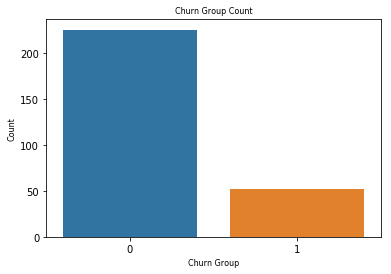

In [27]:
### aggregates on two groups of users
churn_user_df=spark.sql('''

                select distinct userId, churn, count(*) as count
                from user_log_data
                group by userId, churn

        '''
).toPandas()



#create barplot
sns.countplot(data = churn_user_df, x = 'churn')
plt.title('Churn Group Count', fontsize=8)
plt.xlabel('Churn Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
#user_log_df.plot.hist()

Text(0,0.5,'gender')

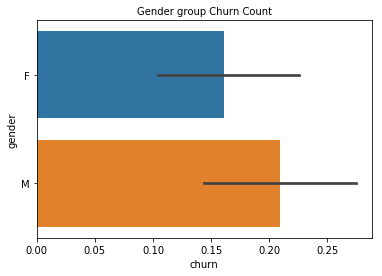

In [28]:
### aggregates on two groups of users by gender, churn
gender_user_df=spark.sql('''
            select userId,gender, churn, count(*) as count
            from user_log_data
            group by userId,gender, churn '''
).toPandas()



#create barplot

sns.barplot(x="churn", y="gender",  data=gender_user_df)
plt.title('Gender group Churn Count', fontsize=10)
plt.xlabel('churn', fontsize=10)
plt.ylabel('gender', fontsize=10)


Text(0,0.5,'itemInSession')

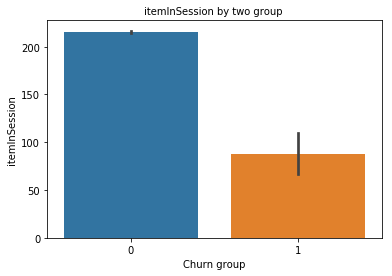

In [29]:
### aggregates on two groups of users by itemInsession
itemInSession_df=spark.sql('''
            select userId,itemInSession, churn,count(*) as count
            from user_log_data
            group by userId,itemInSession, churn
        '''
).toPandas()


#create barplot

sns.barplot(x="churn", y="itemInSession", data=itemInSession_df)
plt.title('itemInSession by two group ', fontsize=10)
plt.xlabel('Churn group', fontsize=10)
plt.ylabel('itemInSession', fontsize=10)


Text(0,0.5,'max_plays')

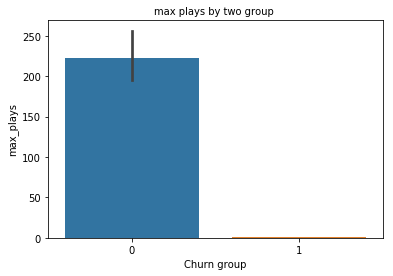

In [30]:
### How many songs were played from the two groups
###observing how much of a specific action they experienced per a certain time unit or number of songs played.
song_played = spark.sql('''
                        select Song, churn, userId,count(*) as plays
                        from user_log_data
                        group by Song, churn,userId
''')

# save the results in a new view
song_played.createOrReplaceTempView("song_played")

play_counts_df=spark.sql('''
            SELECT max(plays) AS max_plays, churn,userId
                    FROM song_played
                    group by churn, userId

'''
).toPandas()

sns.barplot(x="churn", y="max_plays", data=play_counts_df)
plt.title('max plays by two group ', fontsize=10)
plt.xlabel('Churn group', fontsize=10)
plt.ylabel('max_plays', fontsize=10)


Text(0,0.5,'page')

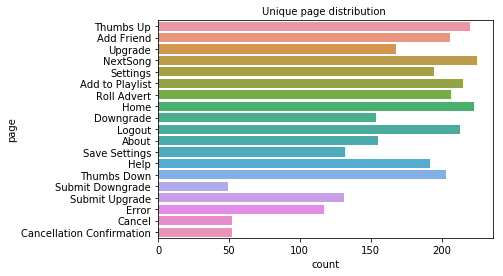

In [31]:
# use a self join to find where the max play equals the count value

page_distr=spark.sql('''SELECT distinct page, userId, churn
                    From user_log_data
          ''').toPandas()

sns.countplot(data = page_distr, y = 'page')
plt.title('Unique page distribution ', fontsize=10)
plt.xlabel('count', fontsize=10)
plt.ylabel('page', fontsize=10)

           AVG  churn  userID      page
220  22.215517      0     126  NextSong
221  15.500000      0  100019  NextSong
222  15.307692      0     148  NextSong
223  22.926829      0      25  NextSong
224  15.800000      0  200010  NextSong


Text(0,0.5,'AVG')

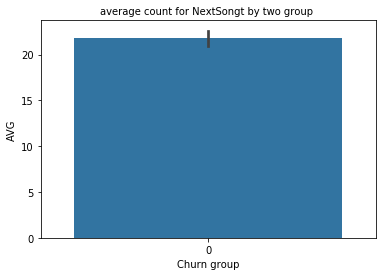

In [32]:
#How many songs do users listen to on average between visiting our home page?

get_hour=spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_home = spark.sql('''SELECT userId, churn,page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home 
                    FROM user_log_data
                    WHERE ((page='NextSong') or (page = 'Home'))

            ''')

# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql('''SELECT *, 
        SUM(is_home) OVER (PARTITION BY userID, churn ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period
    FROM is_home_table''')

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# find the average count for NextSong
nextsong_df=spark.sql('''SELECT AVG(count_results) as AVG, churn, userID, page
             from (SELECT userID, churn, page, period,COUNT(*) AS count_results 
                    FROM period_table 
                    GROUP BY userID, period, page ,churn
                    HAVING page = 'NextSong')
             group by churn, userID, page
                    ''').toPandas()

print(nextsong_df.tail(5))
sns.barplot(x="churn", y="AVG", data=nextsong_df)
plt.title('average count for NextSongt by two group ', fontsize=10)
plt.xlabel('Churn group', fontsize=10)
plt.ylabel('AVG', fontsize=10)

Text(0,0.5,'plays_per_hour')

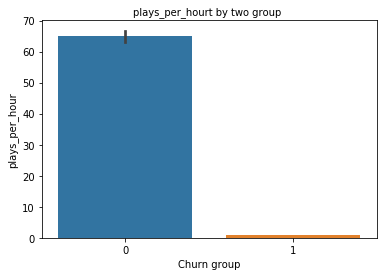

In [33]:
get_hour=spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

songs_in_hour = spark.sql('''
          SELECT get_hour(ts) AS hour, churn, userId, COUNT(*) as plays_per_hour
          FROM user_log_data
          GROUP BY hour, churn, userId
          ORDER BY cast(hour as int) ASC
          '''
          )

songs_in_hour_df = songs_in_hour.toPandas()

sns.barplot(x="churn", y="plays_per_hour", data=songs_in_hour_df)
plt.title('plays_per_hourt by two group ', fontsize=10)
plt.xlabel('Churn group', fontsize=10)
plt.ylabel('plays_per_hour', fontsize=10)

Text(0,0.5,'page vist')

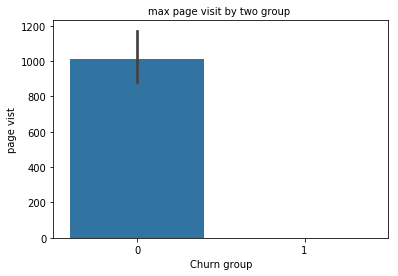

In [34]:
# SELECT distinct pages for the churn user and distinc pages for all users
# Right join the results to find pages that churn visitor did not visit
page_visit=spark.sql('''

            select max(user_pages.page_visit) as page_visit,user_pages.churn as churn, user_pages.userId as userId
            from (
                select distinct page,churn, userId, count(*) page_visit
                from user_log_data
                group by userId, churn, page
                ) as user_pages
            right join 
            (select distinct page
            from user_log_data        
            ) as all_pages
            on user_pages.page=all_pages.page
            Group by churn, userId
           ''' )

page_visit_df = page_visit.toPandas()
#songs_in_hour_df.plot.hist()

sns.barplot(x="churn", y="page_visit", data=page_visit_df)
plt.title('max page visit by two group ', fontsize=10)
plt.xlabel('Churn group', fontsize=10)
plt.ylabel('page vist', fontsize=10)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [35]:
get_hour=spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))
full_data=spark.sql('''
            select distinct sq.userId,
                   sq.churn,
                   case when sq.gender= 'M' then 2
                        when sq.gender ='F' then 1  else 0 end as gender,
                   case when sq.level='padid' then 2
                        when sq.level='free' then 1 else 0 end as padi_level,
                   case when (sq.page='Thumbs Down') then count(*) over(partition by userId, churn order by hour)
                        else 0 end as thumbs_down_count,
                   case when (sq.page='Thumbs Up') then count(*) over(partition by userId, churn order by hour)
                        else 0 end as thumbs_up_count,
                   count(page) over(partition by userId, churn order by hour) as page_vist_ct_hour,
                   AVG(itemInsession) over(partition by userId, churn order by hour) as avg_item_hour,
                   count(song) over(partition by userId,churn order by hour) as max_play_hour,
                   AVG(length) over(partition by userId, churn order by hour) as avg_length_hour
            from(
            select userId,itemInSession, page, churn, gender, song, level,length,get_hour(ts) as hour
            from user_log_data
            )sq

           ''' )
print(full_data.printSchema())
full_data_df=full_data.toPandas()
print(full_data_df.head())
print(full_data_df.shape)

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- padi_level: integer (nullable = false)
 |-- thumbs_down_count: long (nullable = false)
 |-- thumbs_up_count: long (nullable = false)
 |-- page_vist_ct_hour: long (nullable = false)
 |-- avg_item_hour: double (nullable = true)
 |-- max_play_hour: long (nullable = false)
 |-- avg_length_hour: double (nullable = true)

None
   userId  churn  gender  padi_level  thumbs_down_count  thumbs_up_count  \
0     105      1       2           0                  0                0   
1      17      1       1           0                  0                0   
2      30      0       2           0                  0                0   
3      30      0       2           1                  0                0   
4      30      0       2           1                 67                0   

   page_vist_ct_hour  avg_item_hour  max_play_hour  avg_length_hour  
0                  1  

In [36]:
full_data.dropDuplicates()
print(full_data.take(5))
print(full_data.printSchema())
print((full_data.count(), len(full_data.columns)))

[Row(userId=105, churn=1, gender=2, padi_level=0, thumbs_down_count=0, thumbs_up_count=0, page_vist_ct_hour=1, avg_item_hour=332.0, max_play_hour=0, avg_length_hour=None), Row(userId=17, churn=1, gender=1, padi_level=0, thumbs_down_count=0, thumbs_up_count=0, page_vist_ct_hour=1, avg_item_hour=273.0, max_play_hour=0, avg_length_hour=None), Row(userId=30, churn=0, gender=2, padi_level=0, thumbs_down_count=0, thumbs_up_count=0, page_vist_ct_hour=67, avg_item_hour=33.850746268656714, max_play_hour=58, avg_length_hour=247.38093982758625), Row(userId=30, churn=0, gender=2, padi_level=1, thumbs_down_count=0, thumbs_up_count=0, page_vist_ct_hour=67, avg_item_hour=33.850746268656714, max_play_hour=58, avg_length_hour=247.38093982758625), Row(userId=30, churn=0, gender=2, padi_level=1, thumbs_down_count=67, thumbs_up_count=0, page_vist_ct_hour=67, avg_item_hour=33.850746268656714, max_play_hour=58, avg_length_hour=247.38093982758625)]
root
 |-- userId: integer (nullable = true)
 |-- churn: inte

In [37]:
### drop na rows
full_data=full_data.dropna()
print((full_data.count(), len(full_data.columns)))

(11452, 10)


In [38]:
full_data.select([count(when(isnan(c), c)).alias(c) for c in full_data.columns]).show()

### Get count of null in pyspark
full_data.select([count(when (col(c).isNull(), c)).alias(c) for c in full_data.columns]).show()

+------+-----+------+----------+-----------------+---------------+-----------------+-------------+-------------+---------------+
|userId|churn|gender|padi_level|thumbs_down_count|thumbs_up_count|page_vist_ct_hour|avg_item_hour|max_play_hour|avg_length_hour|
+------+-----+------+----------+-----------------+---------------+-----------------+-------------+-------------+---------------+
|     0|    0|     0|         0|                0|              0|                0|            0|            0|              0|
+------+-----+------+----------+-----------------+---------------+-----------------+-------------+-------------+---------------+

+------+-----+------+----------+-----------------+---------------+-----------------+-------------+-------------+---------------+
|userId|churn|gender|padi_level|thumbs_down_count|thumbs_up_count|page_vist_ct_hour|avg_item_hour|max_play_hour|avg_length_hour|
+------+-----+------+----------+-----------------+---------------+-----------------+------------

In [39]:
selected_data=full_data.drop('userId')
print(selected_data.printSchema())
print((selected_data.count(), len(selected_data.columns)))

features_data=full_data.drop('userId', 'churn')
feature_list = features_data.columns[:]
print(feature_list)

#feature_columns = [col for col in features_data.columns if col!='churn']
#feature_columns


root
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- padi_level: integer (nullable = false)
 |-- thumbs_down_count: long (nullable = false)
 |-- thumbs_up_count: long (nullable = false)
 |-- page_vist_ct_hour: long (nullable = false)
 |-- avg_item_hour: double (nullable = true)
 |-- max_play_hour: long (nullable = false)
 |-- avg_length_hour: double (nullable = true)

None
(11452, 9)
['gender', 'padi_level', 'thumbs_down_count', 'thumbs_up_count', 'page_vist_ct_hour', 'avg_item_hour', 'max_play_hour', 'avg_length_hour']


In [40]:
full_data_df.describe()

,userId,churn,gender,padi_level,thumbs_down_count,thumbs_up_count,page_vist_ct_hour,avg_item_hour,max_play_hour,avg_length_hour
count,11506.000000,11506.000000,11506.000000,11506.000000,11506.000000,11506.000000,11506.000000,11506.000000,11506.000000,11452.000000
mean,61529.622110,0.004519,1.492265,0.353642,174.722319,346.343560,957.411438,102.899998,786.061359,249.317780
std,104413.300202,0.067077,0.499962,0.478120,638.438451,798.972878,1080.943580,60.380148,893.719943,7.585763
min,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,187.833020
25%,53.000000,0.000000,1.000000,0.000000,0.000000,0.000000,251.000000,60.781178,200.000000,246.501098
50%,103.000000,0.000000,1.000000,0.000000,0.000000,0.000000,628.000000,94.650392,508.000000,249.003767
75%,100015.000000,0.000000,2.000000,1.000000,0.000000,309.750000,1291.000000,133.525428,1064.250000,251.847064
max,300025.000000,1.000000,2.000000,1.000000,9632.000000,9632.000000,9632.000000,461.057143,8002.000000,488.646080


In [41]:
def fit_transform_pipeline(data):
    '''
    '''
    #create vector assembler of numerical features
    feature_list = features_data.columns[:]
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    
    pipeline = Pipeline(stages=[assembler,scaler])
    scalerModel = pipeline.fit(data)
    scaledData = scalerModel.transform(data)
    return scaledData

In [42]:
# Split the data into train, test and validation
# train, test = selected_data.randomSplit([.8, .2], seed=42)

In [43]:
# # split the full dataset into train, test, and validation sets
train, test, val = selected_data.randomSplit([0.6, 0.2, 0.2], seed=42)
# # display shape of datasets
print('selected data shape: {}, {}'.format(selected_data.count(), len(selected_data.columns)))
print('train shape: {}, {}'.format(train.count(), len(train.columns)))
print('test shape: {}, {}'.format(test.count(),len(test.columns)))
print('validation shape: {}, {}'.format(val.count(), len(val.columns)))

selected data shape: 11452, 9
train shape: 6873, 9
test shape: 2260, 9
validation shape: 2319, 9


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [44]:
def build_model(classifier, param):      ###reference: https://www.kaggle.com/yukinagae/sparkify-project-churn-prediction
    '''
    input:
    classifier - Machine Learning classifier 
    param - parameters provided
    
    output:
    model - tuned model of chosen classifier
    '''
    #create vector assembler of numerical features
    feature_list = features_data.columns[:]
    assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    
    pipeline = Pipeline(stages=[assembler,scaler, classifier])

    #Parameter tuning
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=2,
    )
    return model


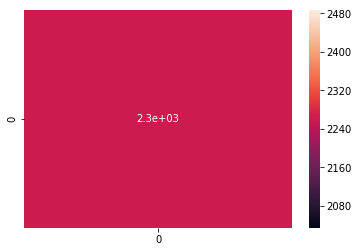

Logistic Regression F1-score:  1.0
Logistic Regression accuracy: 1.0


In [45]:
#Logistic Regression Training

lr = LogisticRegression(labelCol="churn", featuresCol="scaled_features")
param = ParamGridBuilder()\
        .addGrid(lr.regParam,[0.1, 0.3])\
        .addGrid(lr.fitIntercept, [False, True])\
        .addGrid(lr.maxIter, [2,3])\
        .build()

# Build model
model_lr = build_model(lr, param)

# train model
model_lr_trained=model_lr.fit(train)
lr_testresult=model_lr_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
cm = confusion_matrix(lr_testresult.select(['churn']).toPandas(), lr_testresult.select(['prediction']).toPandas())
sns.heatmap(cm, annot=True)
plt.show()


# Model evaluation
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
lr_testresult=lr_testresult.withColumn('label', lr_testresult.churn)

lr_f1_test = evaluator.evaluate(lr_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Logistic Regression F1-score: ',lr_f1_test)
lr_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churn')
print ('Logistic Regression accuracy:', lr_accuracy.evaluate(lr_testresult))

+-----+-----+
|churn|count|
+-----+-----+
|    0| 2260|
+-----+-----+



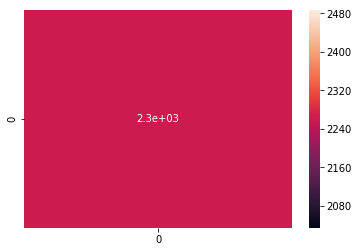

Random Forest F1-score:  1.0
Random Forest accuracy: 1.0


In [46]:
#Random Forest Training
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features")
paramrf = ParamGridBuilder()\
        .addGrid(rf.numTrees, range(5, 65, 6)) \
        .build()

model_rf = build_model(rf, paramrf)
model_rf_trained = model_rf.fit(train)
rf_testresult = model_rf_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
rf_testresult.select(['churn']).groupby('churn').count().show()
cm = confusion_matrix(rf_testresult.select(['churn']).toPandas(), rf_testresult.select(['prediction']).toPandas())
sns.heatmap(cm, annot=True)
plt.show()

rf_testresult=rf_testresult.withColumn('label', rf_testresult.churn)
rf_f1_test = evaluator.evaluate(rf_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Random Forest F1-score: ',rf_f1_test)
rf_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churn')
print ('Random Forest accuracy:', rf_accuracy.evaluate(rf_testresult))

+-----+-----+
|churn|count|
+-----+-----+
|    0| 2260|
+-----+-----+



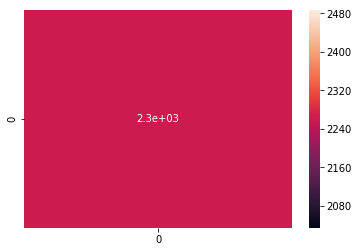

Gradient Boosted Trees F1-score:  1.0
Gradient Boosted Trees accuracy: 1.0


In [47]:
#Gradient Boosted Trees
gbt = GBTClassifier(labelCol="churn", featuresCol="scaled_features")
paramgbt = ParamGridBuilder()\
        .addGrid(gbt.maxDepth, [2, 5])\
        .addGrid(gbt.maxIter, [5, 10])\
        .build()

model_gbt = build_model(gbt, paramgbt)
model_gbt_trained = model_gbt.fit(train)
gbt_testresult = model_gbt_trained.transform(test)

#Plot confusion matrix and print f1 score and accuracy
gbt_testresult.select(['churn']).groupby('churn').count().show()
cm = confusion_matrix(gbt_testresult.select(['churn']).toPandas(), gbt_testresult.select(['prediction']).toPandas())
sns.heatmap(cm, annot=True)
plt.show()

gbt_testresult=gbt_testresult.withColumn('label', rf_testresult.churn)
gbt_f1_test = evaluator.evaluate(gbt_testresult.select('label','prediction'),{evaluator.metricName: 'f1'})
print('Gradient Boosted Trees F1-score: ',gbt_f1_test)
gbt_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy', labelCol='churn')
print ('Gradient Boosted Trees accuracy:', rf_accuracy.evaluate(gbt_testresult))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.